# `NoEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.noepistasis` model.

## Set up
Import Python modules:

In [1]:
import math
import random
import warnings

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 50  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 50 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

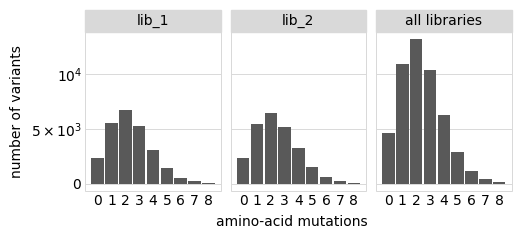

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variants
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    norm_weights=((0.4, -0.5, 0.7), (0.6, -5, 1.5)),
                    )

But since we are using a non-epistatic (linear model), we will simulate variants according to the *latent phenotype* rather than their *observed phenotype* (since in a non-epistatic model these two are the same).
First, look at the distribution of latent phenotypes for all single mutants (the dashed orange line is the latent phenotype of wildtype):

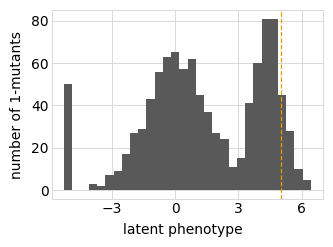

In [10]:
p = phenosimulator.plotMutsHistogram('latent')
_ = p.draw()

Our simulation function is then the exponential of the latent phenotype, as mutants as the functional scores represent the log enrichment:

In [11]:
def phenotype_func(x):
    return math.exp(phenosimulator.latentPhenotype(x))

Now we simulate the counts, passing to the simulate function the latent rather than observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenotype_func,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

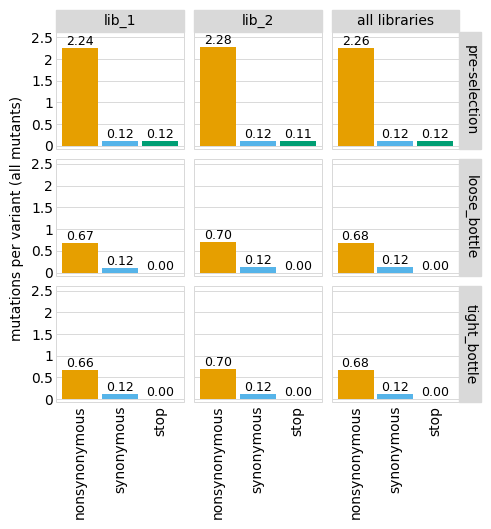

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,56082223,25000000,2.243289
1,lib_1,pre-selection,synonymous,3015878,25000000,0.120635
2,lib_1,pre-selection,stop,2895182,25000000,0.115807
3,lib_1,loose_bottle,nonsynonymous,16748476,25000000,0.669939
4,lib_1,loose_bottle,synonymous,2893599,25000000,0.115744
5,lib_1,loose_bottle,stop,165,25000000,0.000007
6,lib_1,tight_bottle,nonsynonymous,16576156,25000000,0.663046
7,lib_1,tight_bottle,synonymous,2877873,25000000,0.115115
8,lib_1,tight_bottle,stop,128,25000000,0.000005
9,lib_2,pre-selection,nonsynonymous,56906185,25000000,2.276247


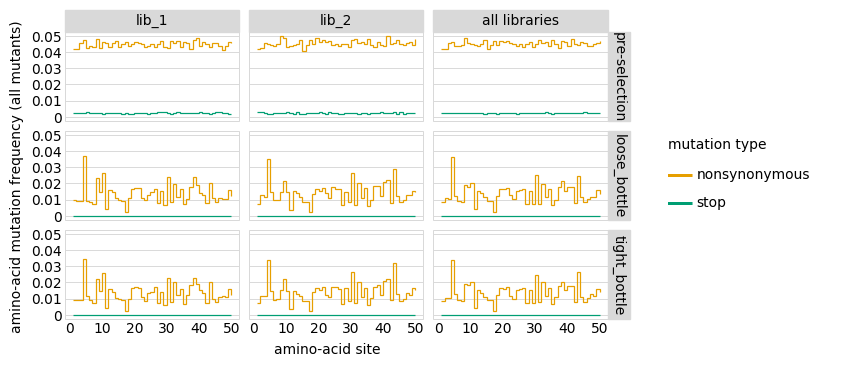

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

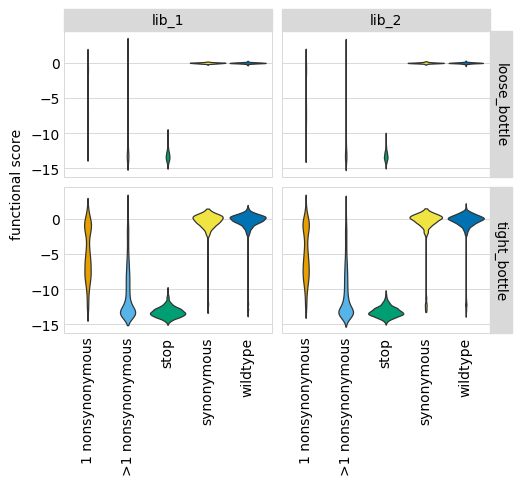

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Fit `NoEpistasis` model

Focus just on loose bottleneck for now:

In [20]:
func_scores = func_scores.query('post_sample == "loose_bottle"')

Make a binary map for the variants:

In [21]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 1000


Now initialize the `NoEpistasis` model:

In [22]:
noepistasis_model = dms_variants.globalepistasis.NoEpistasis(binarymap)

In [23]:
noepistasis_model.latent_phenotype_frombinary(binarymap.binary_variants)

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
noepistasis_model.observed_phenotype_frombinary(binarymap.binary_variants)

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
noepistasis_model.nparams

1002

In [26]:
noepistasis_model.latenteffects_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
noepistasis_model.epistasis_HOC

1.0

In [28]:
noepistasis_model.epistasis_func_params

{}

In [29]:
noepistasis_model.loglik

-899761.3559646559

In [30]:
noepistasis_model.latent_phenotype_wt

0.0

In [31]:
noepistasis_model._fit_latent_leastsquares()

In [32]:
noepistasis_model.loglik

-118952.56384173968

In [33]:
scipy.stats.pearsonr(
        binarymap.func_scores,
        noepistasis_model.latent_phenotype_frombinary(binarymap.binary_variants))

(0.8435293733485107, 0.0)

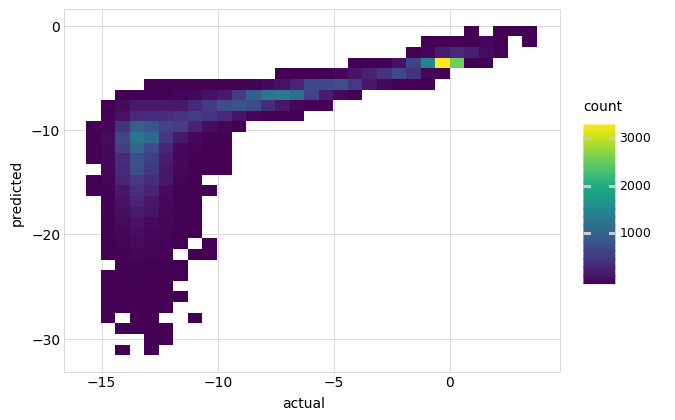

<ggplot: (316470476)>

In [34]:
import pandas as pd
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': noepistasis_model.latent_phenotype_frombinary(binarymap.binary_variants)})

(ggplot(df, aes('actual', 'predicted')) +
 geom_bin2d()
 )

In [35]:
noepistasis_model.epistasis_HOC

5.502259983055581

In [36]:
noepistasis_model.latent_phenotype_wt

-3.1289725862618374

In [38]:
import time
start = time.time()
noepistasis_model.fit()
print(f"Fitting took {time.time() - start}")

Fitting took 177.77393579483032


In [39]:
noepistasis_model.loglik

-117884.28646552972

In [40]:
noepistasis_model.epistasis_HOC

4.302191677123483

In [41]:
noepistasis_model.latent_phenotype_wt

-2.38643805408621

In [42]:
scipy.stats.pearsonr(
        binarymap.func_scores,
        noepistasis_model.latent_phenotype_frombinary(binarymap.binary_variants))

(0.8429444514924092, 0.0)

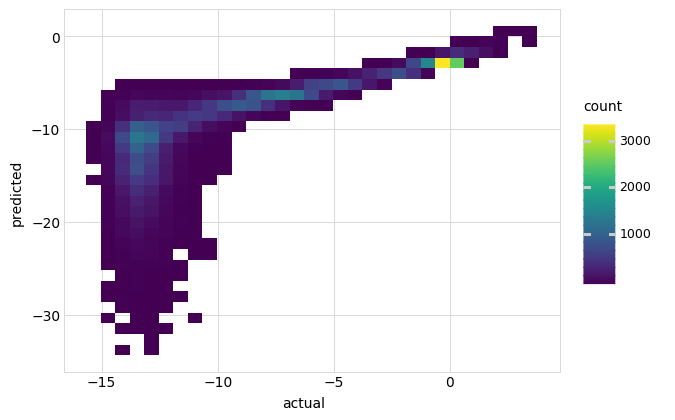

<ggplot: (-9223372036543856738)>

In [43]:
import pandas as pd
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': noepistasis_model.latent_phenotype_frombinary(binarymap.binary_variants)})

(ggplot(df, aes('actual', 'predicted')) +
 geom_bin2d()
 )